In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import shap
import math
import matplotlib.pyplot as plt
from scipy import stats


from combat.pycombat import pycombat
from xgboost import XGBClassifier

# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, RandomizedSearchCV, LearningCurveDisplay, learning_curve
from sklearn.metrics import make_scorer, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, f1_score, make_scorer, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [2]:
os.getcwd()

'/app/script'

In [3]:
os.chdir('../store/DatasetReduced')

<h2>Preparazione dei dati</h2>

In [7]:
dataset = pd.read_csv('../Dataset/MergedDatasetReducedCombat_symbol.csv')
sampleID = dataset['SampleID']
datasetID = dataset['SampleID'].apply(lambda x: x.split('-')[0]).values
indicator = dataset['Label']

def getPatientID(sampleID):
    return sampleID.split('-')[0] + '-' + sampleID.split('-')[1].split('_', 1)[1]

dataset.insert(1, 'PatientID', dataset['SampleID'].apply(getPatientID))
dataset

,SampleID,PatientID,Label,XPO6,ARPC1A,THOP1,ATP2B2,CSTA,PKM,MAPK1IP1L,...,GPR25,LRRC31,GPR88,LAMTOR3,ACTL6A,MS4A6A,BAZ2A,TPM1,DIABLO,DOC2A
0,0-GSM1026056_600009.0001,0-600009.0001,1,10.525171,7.022214,6.483224,5.848133,7.591375,8.987009,9.548412,...,6.119568,3.828953,5.485397,8.391649,6.906047,9.119511,7.989939,7.300196,7.917960,5.448753
1,0-GSM1026057_600009.0001-FollowUp_1,0-600009.0001,1,10.881165,6.973561,6.813249,5.887911,7.668762,9.267965,9.533519,...,6.158344,3.782587,5.483554,8.398246,6.886462,9.133109,8.325695,7.226071,7.920274,5.776065
2,0-GSM1026058_41461.0001,0-41461.0001,1,11.430331,7.140780,6.688973,5.984697,7.571597,9.025906,9.516713,...,6.166022,3.867980,5.531954,8.335890,6.885936,9.222653,8.301554,7.299852,7.866331,5.740622
3,0-GSM1026059_41462.0001,0-41462.0001,1,11.385201,7.144255,6.482745,5.616827,7.819636,9.037302,9.581727,...,6.092625,3.812816,5.393568,8.600387,6.919007,9.323385,8.333977,7.363228,7.953213,5.165763
4,0-GSM1026060_600029.0001,0-600029.0001,1,11.344344,7.067116,6.384345,5.762024,7.962971,9.252510,9.611660,...,6.107478,3.762202,5.412828,8.516187,6.921658,9.388868,8.496262,7.254713,7.891466,5.287396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,6-GSM545842_M10,6-M10,1,10.931859,7.106400,6.789337,6.003297,7.964093,9.272532,9.508226,...,6.134278,3.802080,5.432256,8.533130,6.862112,9.286014,8.442553,7.370798,7.970275,5.338771
725,6-GSM545843_M11,6-M11,1,10.765313,7.079116,6.572470,5.744757,7.963980,9.123222,9.528200,...,6.090562,3.982923,5.388578,8.549721,6.990629,9.269902,8.108137,7.307330,7.984256,5.452894
726,6-GSM545844_M11-FollowUp_1,6-M11,1,10.977433,7.030231,6.554086,5.716029,7.972142,9.102181,9.592449,...,6.046938,3.812349,5.397380,8.556445,6.971580,9.253054,8.279138,7.338065,7.993246,5.532808
727,6-GSM545845_M12,6-M12,1,10.589295,7.081161,6.484474,5.744757,7.956867,9.140242,9.534618,...,6.107268,3.955092,5.404604,8.576988,6.969681,9.256837,8.083611,7.385615,7.974383,5.427824


<h2>Analisi di correlazione</h2>

In [ ]:
current = dataset.copy()
data = current.drop(['SampleID', 'PatientID', 'Label'], axis=1)
dataCorr = data.corr()

joblib.dump(dataCorr, '../store/DatasetReduced/dataReducedCorr.pkl')

In [10]:
dataCorr = joblib.load('../store/DatasetReduced/dataReducedCorr.pkl')
dataCorr

,XPO6,ARPC1A,THOP1,ATP2B2,CSTA,PKM,MAPK1IP1L,ABCG2,LAMB1,ZBTB25,...,GPR25,LRRC31,GPR88,LAMTOR3,ACTL6A,MS4A6A,BAZ2A,TPM1,DIABLO,DOC2A
XPO6,1.000000,0.225751,0.128831,-0.043816,0.052705,0.011954,0.099506,-0.130483,-0.039740,-0.047004,...,-0.085189,-0.181502,-0.054260,-0.100006,-0.152093,-0.074091,0.470530,0.012775,0.010890,-0.041454
ARPC1A,0.225751,1.000000,0.095251,-0.097418,0.235567,-0.137839,0.072462,-0.039065,-0.096349,0.090316,...,-0.078736,-0.097540,-0.043639,0.053077,0.140970,0.201111,-0.026642,0.003498,0.258386,-0.080100
THOP1,0.128831,0.095251,1.000000,0.496122,-0.067049,0.092580,-0.204692,0.001239,0.319492,-0.028019,...,0.250686,-0.106525,0.352105,-0.268441,-0.214463,-0.149773,-0.234891,-0.124411,-0.069813,0.509858
ATP2B2,-0.043816,-0.097418,0.496122,1.000000,-0.082776,-0.016283,-0.292122,0.044322,0.532037,-0.223986,...,0.325594,0.088704,0.549914,-0.139584,-0.293995,-0.108628,-0.264858,-0.020302,-0.319617,0.568421
CSTA,0.052705,0.235567,-0.067049,-0.082776,1.000000,-0.030453,0.008275,-0.039135,-0.143496,-0.225108,...,-0.077678,0.017141,-0.065366,0.312917,0.055356,0.556479,-0.097093,0.160087,0.214668,-0.059146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MS4A6A,-0.074091,0.201111,-0.149773,-0.108628,0.556479,-0.127827,0.030194,-0.089428,-0.120546,-0.018370,...,-0.113115,-0.008205,-0.112361,0.395533,0.211480,1.000000,-0.015841,0.224491,0.283937,-0.174305
BAZ2A,0.470530,-0.026642,-0.234891,-0.264858,-0.097093,0.150789,0.215143,-0.161918,-0.201846,-0.120945,...,-0.197394,-0.115477,-0.299973,-0.053907,-0.101487,-0.015841,1.000000,0.013458,-0.062607,-0.304362
TPM1,0.012775,0.003498,-0.124411,-0.020302,0.160087,-0.009803,0.106305,0.098813,-0.054680,-0.102873,...,-0.103923,-0.053109,0.012674,0.137963,0.075718,0.224491,0.013458,1.000000,0.136652,-0.054506
DIABLO,0.010890,0.258386,-0.069813,-0.319617,0.214668,-0.117859,0.236843,-0.040179,-0.373005,0.248579,...,-0.205410,-0.077499,-0.286060,0.203066,0.287548,0.283937,-0.062607,0.136652,1.000000,-0.222433


In [11]:
clusters = []
for i in range(0, dataCorr.shape[0]):
    cluster = []
    gene_i = dataCorr.index[i]
    print(i)
    for j in range(0, dataCorr.shape[1]):
        gene_j = dataCorr.columns[j]
        if abs(dataCorr.loc[gene_i, gene_j]) >= 0.9:
            cluster.append(gene_j)
    if len(cluster) > 1:
        clusters.append(cluster)

joblib.dump(clusters, "../store/DatasetReduced/clustersReduced.pkl")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

['../store/DatasetReduced/clustersReduced.pkl']

In [12]:
clusters = joblib.load("../store/DatasetReduced/clustersReduced.pkl")
print(clusters)

gene_list = list(dataset.columns)
print(len(gene_list))

for cluster in clusters:
    for gene in cluster:
        if gene in gene_list:
            gene_list.remove(gene)

print(len(gene_list))

[['OAS3', 'RSAD2', 'IFI44L'], ['DEFA4', 'CEACAM6'], ['HINT1', 'UQCRQ'], ['DEFA4', 'CEACAM6'], ['PRKY', 'TXLNGY', 'RPS4Y1', 'EIF1AY'], ['COX7A2', 'UQCRQ'], ['IFI44', 'RSAD2', 'IFI44L'], ['OAS3', 'IFI44', 'RSAD2', 'IFI44L', 'HERC5'], ['PRKY', 'TXLNGY', 'RPS4Y1', 'EIF1AY'], ['OAS3', 'IFI44', 'RSAD2', 'IFI44L', 'HERC5'], ['PRKY', 'TXLNGY', 'RPS4Y1', 'EIF1AY'], ['RSAD2', 'IFI44L', 'HERC5'], ['PRKY', 'TXLNGY', 'RPS4Y1', 'EIF1AY'], ['HINT1', 'COX7A2', 'UQCRQ']]
11495
11481


In [13]:
current = dataset.copy()
data = current.drop(['SampleID', 'PatientID', 'Label'], axis=1)
representative = {}

for cluster in clusters:
    representative[tuple(cluster)] = ""
    variances = {}
    for var in cluster:
        variances[var] = data[var].var()

    sorted_variances = sorted(variances.items(), key=lambda item: item[1])
    reprs = sorted_variances.pop()[0]
    if reprs not in representative.values():
        representative[tuple(cluster)] = reprs
    else:
        while reprs in representative.values() and sorted_variances != []:
            reprs = sorted_variances.pop()[0]
                
        representative[tuple(cluster)] = reprs

sorted_repr = dict(sorted(representative.items(), key=lambda x: len(x[0])))
cluster_sorted = list(sorted_repr.keys())
unique_clusters = {}
flag=True

for i in range(0, len(cluster_sorted)):
    for j in range(i+1, len(cluster_sorted)):
        if set(cluster_sorted[i]).issubset(set(cluster_sorted[j])):
            flag=False
            break
    if flag==True:
        unique_clusters[cluster_sorted[i]] = sorted_repr[cluster_sorted[i]]
    else:
        flag = True

print(unique_clusters)

{('DEFA4', 'CEACAM6'): 'DEFA4', ('HINT1', 'COX7A2', 'UQCRQ'): 'COX7A2', ('PRKY', 'TXLNGY', 'RPS4Y1', 'EIF1AY'): 'RPS4Y1', ('OAS3', 'IFI44', 'RSAD2', 'IFI44L', 'HERC5'): 'IFI44'}


In [14]:
for gene in list(unique_clusters.values()):
    if gene not in gene_list:
        gene_list.append(gene)

print(len(gene_list))

11485


In [15]:
datasetDeclustered = dataset[gene_list]
datasetDeclustered.to_csv("../store/DatasetReduced/MergedDatasetReducedCombatDeclustered_symbol.csv", index=False)
datasetDeclustered

,SampleID,PatientID,Label,XPO6,ARPC1A,THOP1,ATP2B2,CSTA,PKM,MAPK1IP1L,...,ACTL6A,MS4A6A,BAZ2A,TPM1,DIABLO,DOC2A,DEFA4,COX7A2,RPS4Y1,IFI44
0,0-GSM1026056_600009.0001,0-600009.0001,1,10.525171,7.022214,6.483224,5.848133,7.591375,8.987009,9.548412,...,6.906047,9.119511,7.989939,7.300196,7.917960,5.448753,6.064862,8.905161,6.083871,7.861560
1,0-GSM1026057_600009.0001-FollowUp_1,0-600009.0001,1,10.881165,6.973561,6.813249,5.887911,7.668762,9.267965,9.533519,...,6.886462,9.133109,8.325695,7.226071,7.920274,5.776065,6.204405,9.027083,5.938436,7.793113
2,0-GSM1026058_41461.0001,0-41461.0001,1,11.430331,7.140780,6.688973,5.984697,7.571597,9.025906,9.516713,...,6.885936,9.222653,8.301554,7.299852,7.866331,5.740622,6.051944,8.936827,5.924100,8.199732
3,0-GSM1026059_41462.0001,0-41462.0001,1,11.385201,7.144255,6.482745,5.616827,7.819636,9.037302,9.581727,...,6.919007,9.323385,8.333977,7.363228,7.953213,5.165763,6.114210,9.250595,5.951088,7.803589
4,0-GSM1026060_600029.0001,0-600029.0001,1,11.344344,7.067116,6.384345,5.762024,7.962971,9.252510,9.611660,...,6.921658,9.388868,8.496262,7.254713,7.891466,5.287396,5.935075,9.036619,6.151681,8.945151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,6-GSM545842_M10,6-M10,1,10.931859,7.106400,6.789337,6.003297,7.964093,9.272532,9.508226,...,6.862112,9.286014,8.442553,7.370798,7.970275,5.338771,6.390358,9.111883,6.359453,7.864455
725,6-GSM545843_M11,6-M11,1,10.765313,7.079116,6.572470,5.744757,7.963980,9.123222,9.528200,...,6.990629,9.269902,8.108137,7.307330,7.984256,5.452894,5.961750,9.158106,6.377977,7.876844
726,6-GSM545844_M11-FollowUp_1,6-M11,1,10.977433,7.030231,6.554086,5.716029,7.972142,9.102181,9.592449,...,6.971580,9.253054,8.279138,7.338065,7.993246,5.532808,5.878172,9.134744,6.361933,7.872425
727,6-GSM545845_M12,6-M12,1,10.589295,7.081161,6.484474,5.744757,7.956867,9.140242,9.534618,...,6.969681,9.256837,8.083611,7.385615,7.974383,5.427824,6.514266,9.168598,6.343867,7.930993


<h2>Divisione in train e test</h2>

In [4]:
dataset = pd.read_csv('MergedDatasetReducedCombatDeclustered_symbol.csv')

gruppi = dataset.groupby('PatientID')

def sanity_check(gruppi):
    for group_name, group_data in gruppi:
        if 'Control' in group_data['SampleID'].iloc[0]:
            for e in group_data['SampleID']:
                if not 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break
        else:
            for e in group_data['SampleID']:
                if 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break

sanity_check(gruppi)

splitter = GroupShuffleSplit(n_splits=2, test_size=0.25, random_state = 42)
split = splitter.split(dataset, groups=dataset['PatientID'])
train_inds, test_inds = next(split)

train = dataset.iloc[train_inds].sample(frac=1, random_state=42)
test = dataset.iloc[test_inds].sample(frac=1, random_state=42)

print("Dataset di train:")
print(train.shape)
print("I malati sono: ", sum(train['Label'] == 1))
print("I sani sono: ", sum(train['Label'] == 0))

print("\nDataset di test:")
print(test.shape)
print("I malati sono: ", sum(test['Label'] == 1))
print("I sani sono: ", sum(test['Label'] == 0))

y_train = train['Label']
x_train = train.drop(columns=['SampleID', 'Label', 'PatientID'])

y_test = test['Label']
x_test = test.drop(columns=['SampleID', 'Label', 'PatientID'])

Dataset di train:
(541, 11485)
I malati sono:  329
I sani sono:  212

Dataset di test:
(188, 11485)
I malati sono:  105
I sani sono:  83


<h1>Addestramento modello</h1>

In [7]:
def prettyPrint(model, name, test=False):
    print(name + ":")
    print("Iperparametri: ", model.best_params_)
    print("Train f1: ", model.score(x_train, y_train))
    print("Mean f1 cross-validated: ", model.best_score_)
    best_index = model.best_index_
    print("\t\t precision \t\t recall \t\t f1-score")
    print(f"0 \t\t {model.cv_results_['mean_test_precision 0'][best_index]:.2f} \t\t\t {model.cv_results_['mean_test_recall 0'][best_index]:.2f}") 
    print(f"1 \t\t {model.cv_results_['mean_test_precision 1'][best_index]:.2f} \t\t\t {model.cv_results_['mean_test_recall 1'][best_index]:.2f}")
    print(f"Accuracy \t\t\t\t\t\t\t {model.cv_results_['mean_test_Accuracy'][best_index]:.2f}")
    print(f"macro avg \t {(model.cv_results_['mean_test_precision 0'][best_index] + model.cv_results_['mean_test_precision 1'][best_index]) / 2:.2f} \t\t\t {(model.cv_results_['mean_test_recall 0'][best_index] + model.cv_results_['mean_test_recall 1'][best_index])/2:.2f} \t\t\t {model.cv_results_['mean_test_f1'][best_index]:.2f}")
    if test:  
        print("\nTest f1 score: ", model.score(x_test, y_test))
        print(classification_report(y_test, model.predict(x_test)), "\n\n")

def randomSearch(pipeline, hyperparameters, iteration, scorer, njobs, x_train, y_train):
    randomSearchResult=RandomizedSearchCV(
    pipeline, 
    param_distributions=hyperparameters,
    n_iter=iteration,
    scoring=scorer,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=njobs,
    refit='f1'
    )

    randomSearchResult.fit(x_train, y_train)
    print("Best model:", randomSearchResult.best_params_)

    return randomSearchResult

def trainModel(pipeline, hyperparameters, scorer, njobs, x_train, y_train): 
    gridSearch = GridSearchCV(pipeline, param_grid=hyperparameters, cv=5, return_train_score=True, scoring=scorer, refit='f1', n_jobs=njobs, verbose=1, error_score='raise')
    gridSearch.fit(x_train, y_train)
    print("Best model:", gridSearch.best_params_)
    return gridSearch

def bayesianOpt(pipeline, hyperparameters, iteration, scorer, njobs, x_train, y_train):
    bayesianSearchResult = BayesSearchCV(estimator = pipeline, search_spaces=hyperparameters, cv=5, n_iter=iteration, return_train_score=True,  refit='f1', scoring=scorer, n_jobs=njobs, verbose=1)
    bayesianSearchResult.fit(x_train, y_train)
    print("Iperparametri:", bayesianSearchResult.best_params_)
    return bayesianSearchResult

In [8]:
pipeline = Pipeline(steps=[('scaling', MinMaxScaler()), ('smote', SMOTE(random_state=42, sampling_strategy='minority', k_neighbors=5)), ('classifier', XGBClassifier(random_state=42))])

def precision_class_0(y_true, y_pred):
    return precision_score(y_true, y_pred, average=None)[0]

def precision_class_1(y_true, y_pred):
    return precision_score(y_true, y_pred, average=None)[1]

def recall_class_0(y_true, y_pred):
    return recall_score(y_true, y_pred, average=None)[0]

def recall_class_1(y_true, y_pred):
    return recall_score(y_true, y_pred, average=None)[1]

scorer = {
    'Accuracy': 'accuracy',
    'precision 0': make_scorer(precision_class_0),
    'precision 1': make_scorer(precision_class_1),
    'recall 0': make_scorer(recall_class_0),
    'recall 1': make_scorer(recall_class_1),
    'f1': make_scorer(f1_score, average='macro')
}

<h3>Bayesian Hyperparameter Optimization</h3>

In [ ]:
param_dist = {
    'classifier__n_estimators': Integer(50, 600),  # Numero di alberi
    'classifier__max_depth': Integer(2, 15),  # Profondità dell'albero
    'classifier__learning_rate': Real(0.001, 1, prior='log-uniform'),  # Tasso di apprendimento
    'classifier__gamma': Real(0.0001, 100, prior='log-uniform'),  # Minimum loss reduction
    'classifier__min_child_weight': Integer(1, 10), 
    'classifier__reg_alpha': Real(0.0001, 100, prior='log-uniform'),  # Regolarizzazione L1
    'classifier__reg_lambda': Real(0.0001, 100, prior='log-uniform')  # Regolarizzazione L2
}

bayesianOptResult = bayesianOpt(pipeline, param_dist, 600, scorer, 10, x_train, y_train)
# joblib.dump(bayesianOptResult, "../store/DatasetReduced/bayesianOptResult.pkl")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [31]:
bayesianOptResult = joblib.load("bayesianOptResult.pkl")
prettyPrint(bayesianOptResult, "Bayesian Hyperparameter", True)

Bayesian Hyperparameter:
Iperparametri:  OrderedDict([('classifier__gamma', 0.0005089004658008007), ('classifier__learning_rate', 0.09223768234366204), ('classifier__max_depth', 2), ('classifier__min_child_weight', 1), ('classifier__n_estimators', 515), ('classifier__reg_alpha', 0.010764848871144839), ('classifier__reg_lambda', 2.072224750319943)])
Train f1:  1.0
Mean f1 cross-validated:  0.8003225050306837
		 precision 		 recall 		 f1-score
0 		 0.79 			 0.71
1 		 0.83 			 0.88
Accuracy 							 0.81
macro avg 	 0.81 			 0.80 			 0.80

Test f1 score:  0.7399264164827078
              precision    recall  f1-score   support

           0       0.76      0.63      0.69        83
           1       0.74      0.85      0.79       105

    accuracy                           0.75       188
   macro avg       0.75      0.74      0.74       188
weighted avg       0.75      0.75      0.75       188
 




<h3>Iterazioni Bayes Optimizazion</h3>

In [ ]:
param_dist = {
    'classifier__n_estimators': Integer(50, 600),  # Numero di alberi
    'classifier__max_depth': Integer(2, 15),  # Profondità dell'albero
    'classifier__learning_rate': Real(0.001, 1, prior='log-uniform'),  # Tasso di apprendimento
    'classifier__gamma': Real(0.0001, 100, prior='log-uniform'),  # Minimum loss reduction
    'classifier__min_child_weight': Integer(1, 10), 
    'classifier__reg_alpha': Real(0.0001, 100, prior='log-uniform'),  # Regolarizzazione L1
    'classifier__reg_lambda': Real(0.0001, 100, prior='log-uniform')  # Regolarizzazione L2
}

results = []

for i in range(5):
    bayesianOptResult = bayesianOpt(pipeline, param_dist, 600, scorer, 10, x_train, y_train)
    results.append(bayesianOptResult)
    joblib.dump(bayesianOptResult, f"../store/DatasetReduced/bayesianOptExec_{i}.pkl")

In [10]:
for i in range(5):
    prettyPrint(joblib.load(f"bayesianOptExec_{i}.pkl"), f"\nModel {i} :")


Model 0 ::
Iperparametri:  OrderedDict([('classifier__gamma', 0.0001), ('classifier__learning_rate', 0.09252619900655003), ('classifier__max_depth', 2), ('classifier__min_child_weight', 1), ('classifier__n_estimators', 600), ('classifier__reg_alpha', 0.0001552310929716111), ('classifier__reg_lambda', 1.7621752562769528)])
Train f1:  1.0
Mean f1 cross-validated:  0.7970169452879661
		 precision 		 recall 		 f1-score
0 		 0.78 			 0.72
1 		 0.83 			 0.87
Accuracy 							 0.81
macro avg 	 0.80 			 0.79 			 0.80

Model 1 ::
Iperparametri:  OrderedDict([('classifier__gamma', 0.038363444342704216), ('classifier__learning_rate', 0.12644062221324892), ('classifier__max_depth', 2), ('classifier__min_child_weight', 1), ('classifier__n_estimators', 508), ('classifier__reg_alpha', 0.002165971025806161), ('classifier__reg_lambda', 0.29078505758750894)])
Train f1:  1.0
Mean f1 cross-validated:  0.798599307388427
		 precision 		 recall 		 f1-score
0 		 0.79 			 0.72
1 		 0.83 			 0.87
Accuracy 					

<h3>Random + Grid Search</h3>

In [ ]:
param_dist = {
    'classifier__n_estimators': np.linspace(50, 500, 7, dtype=int),  # Numero di alberi
    'classifier__max_depth': np.arange(2, 13),  # Profondità dell'albero
    'classifier__learning_rate': np.linspace(0.01, 0.7, 15),  # Tasso di apprendimento
    'classifier__gamma': [0, 0.1, 0.3, 0.5, 0.7, 1],  # Penalizzazione sulla complessità dell'albero
    'classifier__min_child_weight': [1, 2, 3, 4], 
    'classifier__scale_pos_weight': [1, 400/510],
    'classifier__reg_alpha': [0, 0.1, 0.5, 1, 5, 10],  # Regolarizzazione L1
    'classifier__reg_lambda': [0.1, 1, 10, 20, 50, 100]  # Regolarizzazione L2
}

randomSearchModel = randomSearch(pipeline, param_dist, 5000, scorer, 100, x_train, y_train)

joblib.dump(randomSearchModel, "../store/DatasetReduced/randomSearchModel.pkl")

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


In [6]:
randomSearchModelNew = joblib.load("../store/DatasetReduced/randomSearchModel.pkl")
prettyPrint(randomSearchModelNew, "Gradient Boosting with random search new")

Gradient Boosting with random search new:
Iperparametri:  {'classifier__scale_pos_weight': 1, 'classifier__reg_lambda': 1, 'classifier__reg_alpha': 0.5, 'classifier__n_estimators': 200, 'classifier__min_child_weight': 4, 'classifier__max_depth': 2, 'classifier__learning_rate': 0.20714285714285713, 'classifier__gamma': 0.7}
Train f1:  1.0
Mean f1 cross-validated:  0.7898532155572153
		 precision 		 recall 		 f1-score
0 		 0.77 			 0.72
1 		 0.82 			 0.86
Accuracy 							 0.80
macro avg 	 0.80 			 0.79 			 0.79


In [ ]:
params = {
   "classifier__max_depth": [2, 3, 4],
    "classifier__n_estimators":[160, 180, 200, 220, 240],
    "classifier__learning_rate": [0.01, 0.1, 0.15, 0.2, 0.25],
    'classifier__reg_lambda': [1, 5, 10, 15, 20, 25],
    'classifier__reg_alpha': [0.25, 0.5, 0.75, 1],
    'classifier__gamma': [0, 0.7, 1.5, 5]
}

gradientBoostingBasedOnRandom = trainModel(pipeline, params, scorer, 100, x_train, y_train)
joblib.dump(gradientBoostingBasedOnRandom, "../store/gradientBoostingGridBasedOnRandom_new.pkl")

Fitting 5 folds for each of 7200 candidates, totalling 36000 fits


In [14]:
gradientBoostingBasedOnRandom = joblib.load("../store/DatasetReduced/gradientBoostingGridBasedOnRandom_new.pkl")
prettyPrint(gradientBoostingBasedOnRandom, "Gradient Boosting Grid 1")

Gradient Boosting Grid 1:
Iperparametri:  {'classifier__gamma': 0, 'classifier__learning_rate': 0.25, 'classifier__max_depth': 2, 'classifier__n_estimators': 160, 'classifier__reg_alpha': 0.75, 'classifier__reg_lambda': 5}
Train f1:  1.0
Mean f1 cross-validated:  0.7923281279935347
		 precision 		 recall 		 f1-score
0 		 0.76 			 0.73
1 		 0.83 			 0.85
Accuracy 							 0.80
macro avg 	 0.80 			 0.79 			 0.79


<h3>Vecchi Test</h3>

In [ ]:
param_dist = {
    'classifier__n_estimators': Integer(50, 250),  # Numero di alberi
    'classifier__max_depth': Integer(2, 7),  # Profondità dell'albero
    'classifier__learning_rate': Real(0.00001, 10, prior='log-uniform'),  # Tasso di apprendimento
    'classifier__gamma': Real(0.00001, 10, prior='log-uniform'),  # Minimum loss reduction
    'classifier__min_child_weight': Integer(1, 5), 
    'classifier__reg_alpha': Real(1, 100, prior='log-uniform'),  # Regolarizzazione L1
    'classifier__reg_lambda': Real(1, 100, prior='log-uniform')  # Regolarizzazione L2
}

bayesianOptResult2 = bayesianOpt(pipeline, param_dist, 600, scorer, 10, x_train, y_train)
joblib.dump(bayesianOptResult2, "../store/DatasetReduced/bayesianOptResult2.pkl")

In [13]:
bayesianOptResult2 = joblib.load("bayesianOptResult2.pkl")
prettyPrint(bayesianOptResult2, "Bayesian Hyperparameter")

Bayesian Hyperparameter:
Iperparametri:  OrderedDict([('classifier__gamma', 0.008212743749364987), ('classifier__learning_rate', 0.09344387518666128), ('classifier__max_depth', 2), ('classifier__min_child_weight', 5), ('classifier__n_estimators', 250), ('classifier__reg_alpha', 1.0), ('classifier__reg_lambda', 1.0)])
Train f1:  1.0
Mean f1 cross-validated:  0.7917570911570946
		 precision 		 recall 		 f1-score
0 		 0.77 			 0.72
1 		 0.83 			 0.86
Accuracy 							 0.80
macro avg 	 0.80 			 0.79 			 0.79


<h2>Explorative Plots</h2>

In [32]:
model = joblib.load("bayesianOptResult.pkl")
best_model = model.best_estimator_

<h3>Iteration analysis</h3>

Best 10 validation Accuracy: [322 583 319 340 408 516 319 540 537 433 561 299 510 400 115 475 405 360
 404 590]


<Figure size 1800x1200 with 0 Axes>

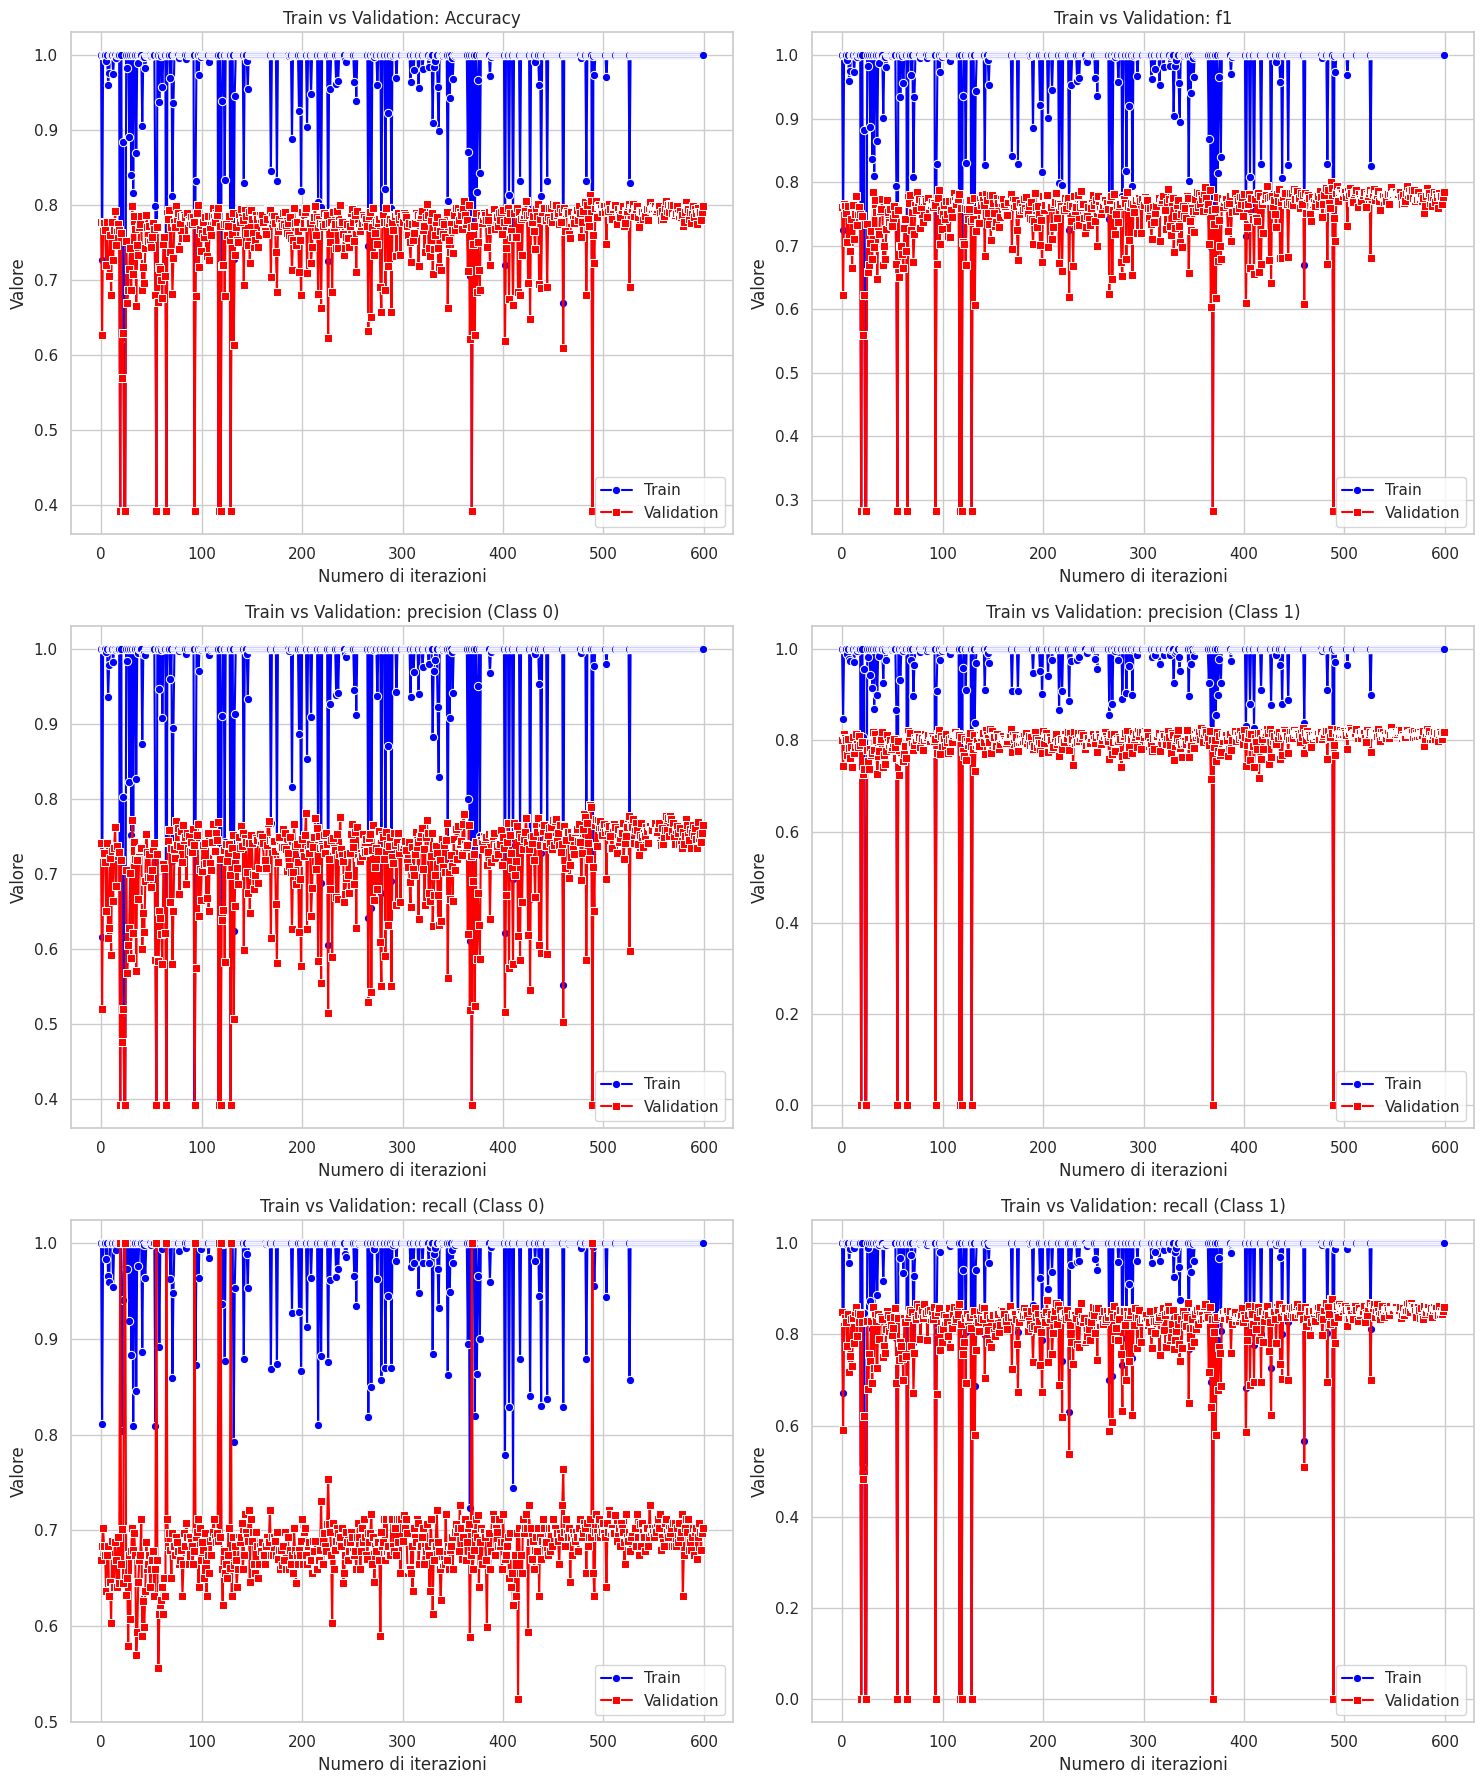

In [42]:
print(f"Best 10 validation Accuracy: {model.cv_results_['rank_test_Accuracy'][:20]}")

resultsDf = pd.DataFrame(model.cv_results_)[['mean_train_Accuracy', 'mean_test_Accuracy', 'mean_train_precision 0', 'mean_test_precision 0', 'mean_test_precision 1', 'mean_train_precision 1', 'mean_train_recall 0','mean_test_recall 0', 'mean_train_recall 1', 'mean_test_recall 1', 'mean_test_f1', 'mean_train_f1']]
#Relevant keys: 'mean_train_Accuracy', 'mean_test_Accuracy', 'mean_train_precision 0', 'mean_test_precision 0', 'mean_test_precision 1', 'mean_train_precision 1', 'mean_train_recall 0','mean_test_recall 0', 'mean_train_recall 1', 'mean_test_recall 1', 'mean_test_f1', 'mean_train_f1'

sns.set(style="whitegrid")
plt.figure(figsize=(18, 12))

# Lista delle metriche da plottare (coppie train/test)
metrics_pairs = [
    ('mean_train_Accuracy', 'mean_test_Accuracy'),
    ('mean_train_f1', 'mean_test_f1'),
    ('mean_train_precision 0', 'mean_test_precision 0'),
    ('mean_train_precision 1', 'mean_test_precision 1'),
    ('mean_train_recall 0', 'mean_test_recall 0'),
    ('mean_train_recall 1', 'mean_test_recall 1')
]

# Creazione dei subplot
n_rows = 3
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 18))

for idx, (train_metric, test_metric) in enumerate(metrics_pairs):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]
    
    sns.lineplot(data=resultsDf, x=resultsDf.index, y=train_metric, label='Train', ax=ax, color='blue', marker='o')
    sns.lineplot(data=resultsDf, x=resultsDf.index, y=test_metric, label='Validation', ax=ax, color='red', marker='s')
    
    metric_name = train_metric.replace('mean_train_', '').replace(' 0', ' (Class 0)').replace(' 1', ' (Class 1)')
    ax.set_title(f'Train vs Validation: {metric_name}')
    ax.set_xlabel('Numero di iterazioni')
    ax.set_ylabel('Valore')
    ax.legend()

# Aggiustamento layout per evitare sovrapposizioni
plt.tight_layout()
plt.show()

sns.reset_defaults()

<h3>Learning Curve</h3>

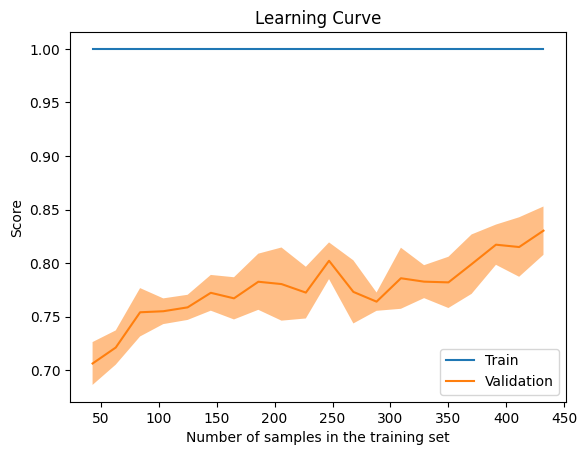

In [39]:
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model,
    X=x_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1, 20),  # 10 punti di addestramento
    cv=5,
    scoring='f1',
    n_jobs=60
)

display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=val_scores, score_name="Score")
display.plot()
plt.title("Learning Curve")
plt.legend(["Train", "Validation"])
plt.show()

<h3>ROC AUC Curve</h3>

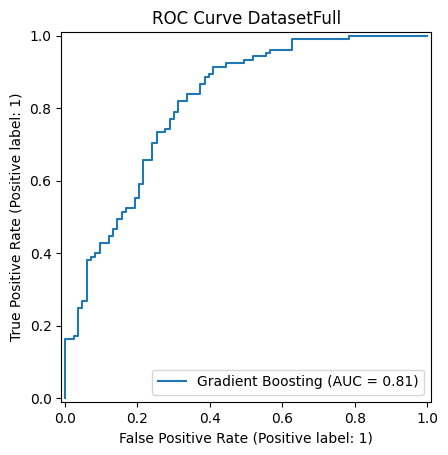

In [40]:
plt.clf()
ax = plt.gca()
ax.set_title('ROC Curve DatasetFull')

svc_disp = RocCurveDisplay.from_estimator(best_model, x_test, y_test, name="Gradient Boosting", ax=ax)
plt.show()

<h3>Confusion Matrices</h3>

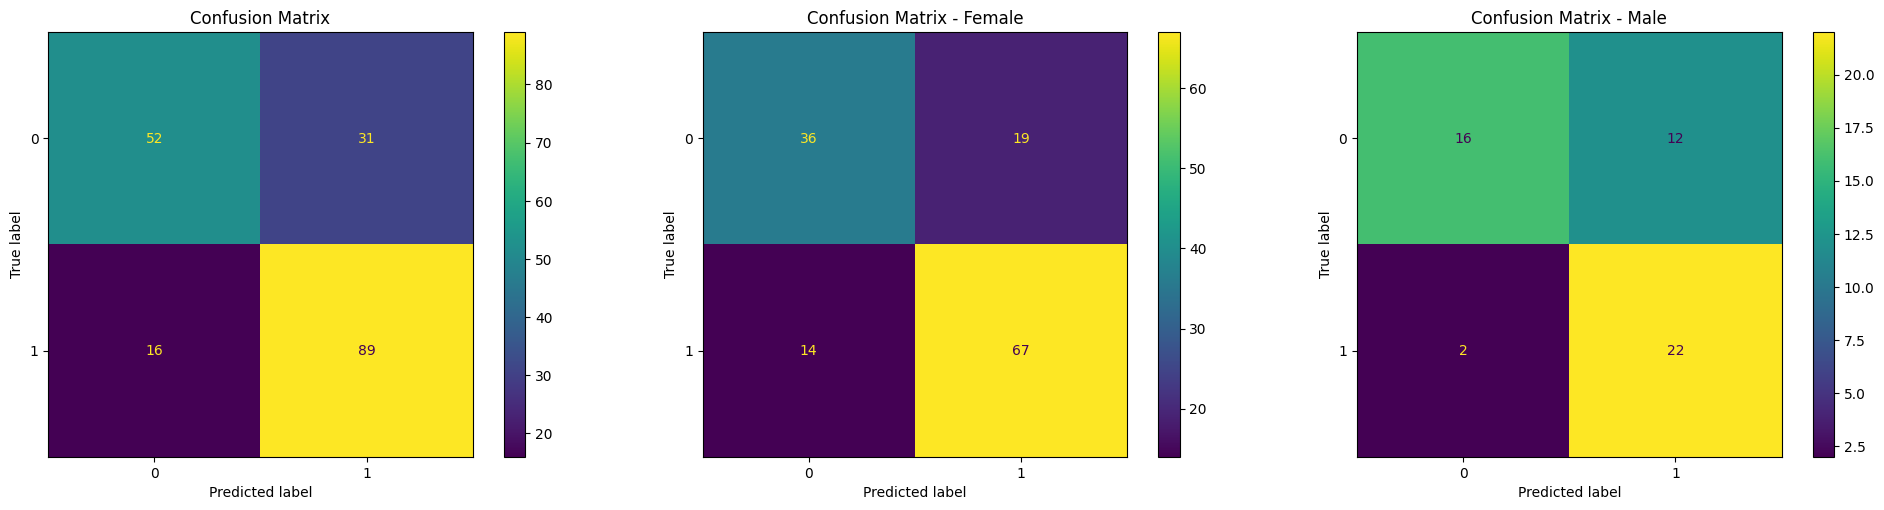

In [41]:
current = dataset.copy()
current['Gender'] = joblib.load('genderReduced.pkl')
current[current['Gender'] == 'Female']

currentTest = pd.merge(current[['SampleID', 'Gender']], test, on='SampleID', how='right')

currentTest['Gender'] = currentTest['Gender'].apply(lambda x: 0 if x == 'female' or x == 'Female' else 1)

female_test = currentTest[currentTest['Gender'] == 0]
df = female_test.copy()

male_test = currentTest[currentTest['Gender'] == 1]
df_male = male_test.copy()

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

ConfusionMatrixDisplay.from_estimator(best_model, x_test, y_test, ax=axes[0])
axes[0].set_title("Confusion Matrix")

ConfusionMatrixDisplay.from_estimator(best_model, df.drop(columns=['SampleID', 'Label', 'PatientID', 'Gender']), female_test['Label'], ax=axes[1])
axes[1].set_title("Confusion Matrix - Female")

ConfusionMatrixDisplay.from_estimator(best_model, df_male.drop(columns=['SampleID', 'Label', 'PatientID', 'Gender']),  male_test['Label'],  ax=axes[2])
axes[2].set_title("Confusion Matrix - Male")

plt.tight_layout()
plt.show()